# Semi Supervised Learning Normalising Flow 

Here we aim to get probability memberships for stars in a cluster based on a semi supevised learning method. The method uses the GMM Flow model. We use stars as classified with extreme high probabiliity from the XDGMM model to label data as beign in the cluster. Moreover we use best isochrone fit to to find more stars which are almost perfect fits. Importantlly we also use this information to label stars which are almost definitely not in the cluster and are field stars. From here we use this information to do a Semi Supervised fit using the GMM Flow

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Cluster_analysis" in os.getcwd()):
    os.chdir("../Data_handling")

from RealNVP import FlowGMM
from gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from vae import Encoder,Decoder, VAE , loss_function, model_train
from sp_vae import ModelVAE,model_trains
from gmm_torch import GaussianMixture

os.chdir("../Cluster_analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Cluster_analysis'

In [2]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)  

### Import Data

In [3]:
os.chdir('../cluster_files')
nf_data=pd.read_csv('vae_data.csv')
os.chdir('../Cluster_analysis')

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_2174/3296965813.py:2: DtypeWarning: Columns (12,13,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  nf_data=pd.read_csv('vae_data.csv')


### Parameters of Interest

In [4]:
columns=['ra','dec','parallax','VRAD','pmra','pmdec','bp_g','g_rp',
'ra_error','dec_error','parallax_error','pmra_error','pmdec_error','phot_g_mean_flux'
,'mean_absolute_mag_g_band','bp_rp','prob'
,'parallax_over_error','phot_g_mean_flux_error','phot_bp_mean_flux_error','phot_rp_mean_flux_error'
,'phot_g_mean_flux_over_error','phot_bp_mean_flux_over_error','phot_rp_mean_flux_over_error','rgeo']


In [5]:
nf_data=nf_data[columns].dropna().reset_index(drop=True)

# Semi Supervised Learning Labelling

We are going to choose stars with the XGDM prob < 1e-50 to be field stars.
We will choose stars with prob >0.999 as being cluster stars

In [6]:
nf_data['l1']=nf_data['prob']>=0.90
nf_data['l2']=nf_data['prob']<1e-50

In [7]:
nf_data['l2'].sum()

9501

In [8]:
nf_data[['l1','l2']]=nf_data[['l1','l2']].astype(int)

In [9]:
nf_data=nf_data.reset_index()

In [10]:
nf_data['l3']=nf_data['l1'] + nf_data['l2']-1

In [11]:
nf_data['labels']=0*nf_data['l1']+nf_data['l2']*1+nf_data['l3']

In [12]:
nf_data

,index,ra,dec,parallax,VRAD,pmra,pmdec,bp_g,g_rp,ra_error,...,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,rgeo,l1,l2,l3,labels
0,0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,0.590866,0.740053,0.062462,...,12.032261,13.133354,1077.94260,123.194890,223.189440,1942.98157,0,1,0,1
1,1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,0.413675,1.044496,0.116390,...,20.419193,49.949870,511.61658,34.331070,31.203371,6141.48389,0,1,0,1
2,2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,0.575531,0.677193,0.061189,...,8.391808,11.373121,1197.15140,168.404950,228.644740,2671.46338,0,0,-1,-1
3,3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,0.585712,0.756983,0.043225,...,15.342039,11.257838,1742.58020,168.069720,457.864930,1887.64343,0,1,0,1
4,4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,0.529069,0.704749,0.036199,...,9.647141,11.867042,2172.79220,385.859700,567.223450,2360.14062,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24570,24570,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,0.790930,0.894377,0.082114,...,9.669498,12.439868,589.08026,84.467860,179.946430,7084.01074,0,0,-1,-1
24571,24571,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,0.720057,0.885668,0.057465,...,8.880351,16.920698,1381.98470,193.339860,258.442700,2100.93555,0,1,0,1
24572,24572,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,1.733685,1.229452,0.071895,...,6.128861,10.157309,994.19196,68.978790,370.094400,7769.46533,0,0,-1,-1
24573,24573,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,0.667429,0.838211,0.090482,...,9.367966,15.222594,943.16860,101.536180,145.135670,4963.53955,0,0,-1,-1


In [13]:
nf_data = nf_data.sample(frac=1).reset_index(drop=True)

In [14]:

x=nf_data[nf_data['l1']==True].sample(n=5000, random_state=1,replace=True).reset_index()

In [15]:
nf_data_orig=nf_data

In [16]:
#nf_data=pd.concat([nf_data,x]).reset_index(drop=True)

# Error

In [17]:
nf_data=nf_data[nf_data['rgeo']<=8000].reset_index(drop=True)
nf_data=nf_data[nf_data['phot_g_mean_flux_error']<1000].reset_index(drop=True)
nf_data=nf_data[nf_data['phot_bp_mean_flux_error']<1000].reset_index(drop=True)
nf_data=nf_data[nf_data['phot_rp_mean_flux_error']<1000].reset_index(drop=True)
nf_data=nf_data[nf_data['pmra_error']<=0.45].reset_index(drop=True)
nf_data=nf_data[nf_data['pmdec_error']<=0.45].reset_index(drop=True)
nf_data=nf_data[nf_data['parallax_error']<=0.2].reset_index(drop=True)

In [18]:
len(nf_data)

20381

# Semisupervised Model Definition

In [19]:
from sklearn.preprocessing import  MinMaxScaler
import torch
scaler=MinMaxScaler()
column_names=['pmra', 'pmdec',
       'rgeo','ra','dec']
#column_names=['ra','dec','pmra','pmdec','mean_absolute_mag_g_band','bp_g','g_rp','bp_rp']
#column_names=['mean_absolute_mag_g_band','bp_rp','ra','dec','rgeo','g_rp','pmra','pmdec']
column_names=['ra','dec','parallax','pmra','pmdec','mean_absolute_mag_g_band','bp_rp','bp_g','g_rp','labels']
scaled_data=scaler.fit_transform(nf_data[column_names].values)

In [20]:
batch_size = int(len(scaled_data)/5) #617 #factor for 1090
lr = 1e-3
epochs = 100

In [21]:
# Target distribution means
r = 0.1
means = torch.tensor([[-r for i in range(len(column_names)-1)], [r for i in range(len(column_names)-1)],[r*(-1)**i for i in range(len(column_names)-1)],[r*(-1)**(i+1) for i in range(len(column_names)-1)]])


from torch.utils.data import DataLoader
# Define distribution. 
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler


X=DataLoader(torch.tensor(scaled_data).float(),batch_size=batch_size,drop_last=True) 
model = FlowGMM(layers=4,n_features=scaled_data[0].shape[-1]-1,mixture_components=2,hidden_dims=[500,25],d=3,means=means)

# Training hyperparameters.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
plot_loss=[]
plotll=[]
plotdet=[]
# Iterate over the number of iterations.
model.train()

for epoch in range(epochs):    
        overall_loss = 0
        for batch_idx, x in enumerate(X):

            x = x.view(batch_size, len(x[0]))
            #x = x.to(DEVICE)
            
            optimizer.zero_grad()

            y,gmm,loss,ll,det = model(x)
            
            
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        plot_loss.append(loss)   
        plotll.append(ll)  
        plotdet.append(det)   
        #print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
        print("ll: "+ str(ll))
        print("Overall Loss: ", overall_loss)
    
print("Finish!!")

ll: tensor(-13.2110, grad_fn=<MeanBackward0>)
Overall Loss:  67.42151641845703
ll: tensor(-12.9952, grad_fn=<MeanBackward0>)
Overall Loss:  63.900864601135254
ll: tensor(-12.8563, grad_fn=<MeanBackward0>)
Overall Loss:  60.687594413757324
ll: tensor(-12.7415, grad_fn=<MeanBackward0>)
Overall Loss:  57.632896423339844
ll: tensor(-12.6160, grad_fn=<MeanBackward0>)
Overall Loss:  54.510199546813965
ll: tensor(-12.4755, grad_fn=<MeanBackward0>)
Overall Loss:  51.07655715942383
ll: tensor(-12.3044, grad_fn=<MeanBackward0>)
Overall Loss:  47.211005210876465
ll: tensor(-12.1255, grad_fn=<MeanBackward0>)
Overall Loss:  42.59272384643555
ll: tensor(-11.8591, grad_fn=<MeanBackward0>)
Overall Loss:  37.59163761138916
ll: tensor(-11.6075, grad_fn=<MeanBackward0>)
Overall Loss:  32.67590665817261
ll: tensor(-11.4252, grad_fn=<MeanBackward0>)
Overall Loss:  27.82492971420288
ll: tensor(-11.2079, grad_fn=<MeanBackward0>)
Overall Loss:  22.82120180130005
ll: tensor(-11.0332, grad_fn=<MeanBackward0>)
O

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
for i in range (len(plot_loss)):
    plot_loss[i]=plot_loss[i].detach().numpy()
    plotll[i]=plotll[i].detach().numpy()
    plotdet[i]=plotdet[i].detach().numpy()

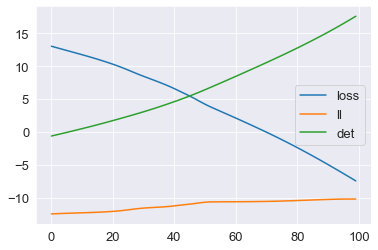

In [ ]:
plt.plot(plot_loss,label='loss')
plt.plot(plotll,label='ll')
plt.plot(plotdet,label='det')
plt.legend()
plt.show()

In [ ]:
y,gmm,loss,ll,det = model(torch.tensor(scaled_data).float())
probs=gmm.log_prob(y).detach().numpy()
y=y.detach().numpy()


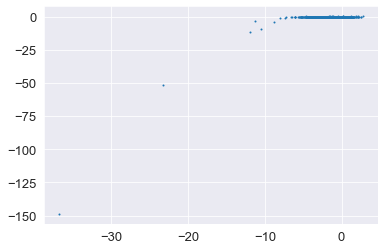

In [ ]:
plt.scatter(y.transpose()[0],y.transpose()[1],s=1)

In [ ]:
import scipy
p=scipy.stats.multivariate_normal(mean= np.zeros(y.shape[-1]),cov=np.eye(y.shape[-1]))

In [ ]:
probs=p.pdf(y)

In [ ]:
probs=probs*det.detach().numpy()

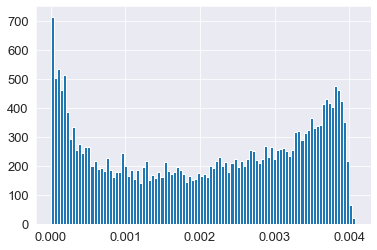

In [ ]:
'''j=0
plt.hist(probs.transpose()[j])
plt.show()'''
plt.hist(probs.transpose(),bins=100)

plt.show()

In [ ]:
'''column=[i for i in range(probs.shape[-1])]
df=pd.DataFrame(data=probs,columns=column)
plotdf=pd.concat([nf_data,df],axis=1)'''
df=pd.DataFrame(data=probs)
plotdf=pd.concat([nf_data,df],axis=1)


In [ ]:
plotdf

,index,ra,dec,parallax,VRAD,pmra,pmdec,bp_g,g_rp,ra_error,...,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,rgeo,l1,l2,l3,labels,level_0,0
0,10679,282.984072,-6.282908,0.129213,0.00,0.244064,-2.071120,0.727980,0.846021,0.075276,...,1091.82790,138.362600,151.330520,6213.127930,0,1,0,1,NaN,0.003399
1,20890,282.732269,-6.063285,0.575446,0.00,-0.756338,-5.947319,0.807705,0.904797,0.048539,...,1672.80110,209.806240,298.669100,1755.864260,0,0,-1,-1,NaN,0.003266
2,10831,282.979594,-6.262522,1.335711,0.00,-1.731670,-5.964342,0.530601,0.774784,0.037931,...,881.77057,307.690400,490.079100,734.797729,0,1,0,1,NaN,0.003004
3,23899,282.904856,-6.043018,0.523793,0.00,-4.833350,-6.893889,0.698956,0.846890,0.043071,...,1815.94960,252.833590,347.276670,1845.948610,0,1,0,1,NaN,0.003534
4,21059,282.609885,-6.084118,0.476255,0.00,-1.759006,-4.099111,0.534485,0.689529,0.045230,...,1584.26770,225.996830,462.918100,2149.735350,0,0,-1,-1,NaN,0.001317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25005,12781,282.741795,-6.277039,0.406434,0.00,-1.714757,-4.113171,0.562656,0.801212,0.127513,...,559.69714,46.817997,53.749214,4049.982910,1,0,0,0,24020.0,0.003474
25006,22167,283.006376,-6.167846,0.406312,0.00,-1.528205,-4.205915,0.597103,0.891056,0.131525,...,642.56244,82.676544,30.877718,3251.675290,1,0,0,0,22086.0,0.003856
25007,11916,282.780877,-6.308429,0.398716,0.00,-1.523274,-4.098610,0.487144,0.687870,0.040134,...,1919.31750,96.875750,282.094700,2495.477780,1,0,0,0,1621.0,0.002670
25008,855,282.851344,-6.185922,0.511343,34.52,-1.533502,-4.139450,0.376822,0.575942,0.029333,...,2566.37920,360.485140,590.625200,1837.706670,1,0,0,0,6461.0,0.000710


In [ ]:
j=0
p=0.0001
data_for_hr1_full=plotdf[plotdf[j]<p]
data_for_hr2_full=plotdf[plotdf['prob']<p]
both_solution=data_for_hr1_full[data_for_hr1_full['prob']<p]

data_for_hr1_full=data_for_hr1_full[data_for_hr1_full['prob']>=p]
data_for_hr2_full=data_for_hr2_full[data_for_hr2_full[j]>=p]

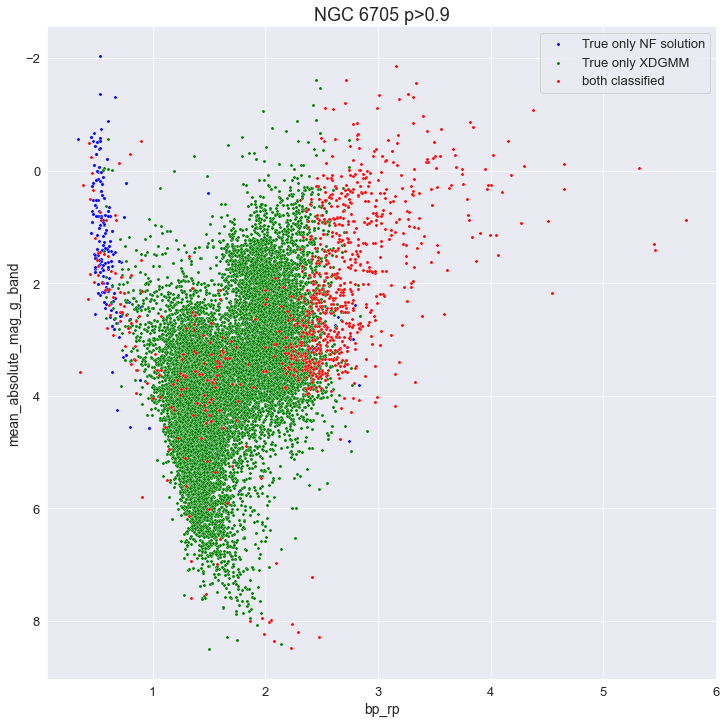

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=data_for_hr1_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True only NF solution',color='b')

scatter=data_for_hr2_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only XDGMM',s=10,color='g')

scatter=both_solution
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='both classified',s=10,color='red')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()